In [1]:
from osgeo import gdal
import numpy as np
import pandas as pd
import os
#import pandas as pd
import matplotlib.pyplot as plt
import sys
import pygmt
from pyproj import Proj, Geod
import rioxarray

sys.path.append('../Functions')
import TiffTools as tt

%load_ext autoreload
%autoreload 2

In [2]:
folder = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/'

P = Proj('epsg:32611')
G = Geod(ellps='WGS84')


In [3]:
tracedf = pd.read_csv('/Volumes/Extreme Pro/Projects/Garlock/GIS/EastPoints.csv')
# Project to UTM
tracedf['x'], tracedf['y'] = P(tracedf.Lon, tracedf.Lat)
# determine primary orientation of the fault, this will detemine sorting
# 0 is ew, 1 is ns
orient = (0 if tracedf.x.max()-tracedf.x.min() > tracedf.y.max()-tracedf.y.min() else 1)
# Sample crossprofiles south to north if ew, else west to east
sample_dir = ('south-to-north' if orient == 0 else 'west-to-east')
# sort 
by = ('x' if orient == 0 else 'y')
tracedf.sort_values(by=by,inplace=True)
# isolate points
fltpts = tracedf[['Lon','Lat']].values

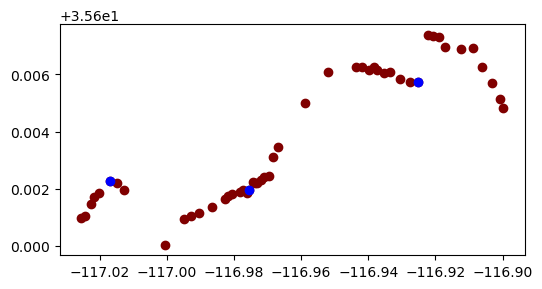

In [4]:
lon1, lat1 = fltpts[5]
az1 = G.inv(fltpts[4][0],fltpts[4][1],fltpts[6][0],fltpts[6][1])[0] - 90

lon2, lat2 = fltpts[20]
az2 = G.inv(fltpts[19][0],fltpts[19][1],fltpts[21][0],fltpts[21][1])[0] - 90

lon3, lat3 = fltpts[40]
az3 = G.inv(fltpts[39][0],fltpts[39][1],fltpts[41][0],fltpts[41][1])[0] - 90

lonlist = [lon1,lon2,lon3]
latlist = [lat1,lat2,lat3]
azlist = [az1,az2,az3]

plt.figure(figsize=(6,3))
plt.scatter(lonlist,latlist,c='blue',zorder=10)
plt.scatter(fltpts[:,0],fltpts[:,1],c='maroon')

In [5]:
savefolder = '/Volumes/Extreme Pro/Projects/Garlock/Deformation/ExampleProfiles/'

In [6]:
# Load deformation grids
# East region, EW
regionl = ['E','E','E','E','E']*3
dirl = ['EW']*5+['NS']*5+['UD']*5
labell = ['Modeled','Ortho','Ortho-Filt','DEM','DEM-Filt']*3
imlist = ['/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/EastdX-rioEPSG4326.tif',
        '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/EWDispStackedEPSG4326.tif',
        '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/EWDispStackedEPSG4326_bidenoise_filtered.tif',
        '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/EWmicmacEPSG4326.tif',
        '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/EWmicmacEPSG4326_bidenoise_filtered.tif',
        # East region, NS
        '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/EastdY-rioEPSG4326.tif',
        '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/NSDispStackedEPSG4326.tif',
        '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/NSDispStackedEPSG4326_bidenoise_filtered.tif',
        '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/NSmicmacEPSG4326.tif',
        '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/NSmicmacEPSG4326_bidenoise_filtered.tif',
        # East region, UD
        '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/EastdZ-rio-x4EPSG4326.tif',
        '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/UDfromHDispStackedEPSG4326_bidenoise_filtered.tif',
        '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/UDfromHDispStackedEPSG4326_bidenoise_filtered_refiltered.tif',
        '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/UDmicmacEPSG4326_bidenoise_filtered.tif',
        '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/UDfromHdispStackedEPSG4326_bidenoise_filtered_refiltered.tif']

corrlist = [None,
        '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/CorrelStackedEPSG4326.tif',
        '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/CorrelStackedEPSG4326.tif',
        '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/CorrelmicmacEPSG4326.tif',
        '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/CorrelmicmacEPSG4326.tif',
        # East region, NS
        None,
        '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/CorrelStackedEPSG4326.tif',
        '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/CorrelStackedEPSG4326.tif',
        '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/CorrelmicmacEPSG4326.tif',
        '/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/defaultsMECdem/CorrelmicmacEPSG4326.tif',
        # East region, UD
        None,
        None,
        None,
        None,
        None,]


In [15]:
for i,image,corrf,region,direct,label in zip(np.arange(0,len(imlist)),imlist[3:4],corrlist[3:4],regionl[3:4],dirl[3:4],labell[3:4]):
    im = rioxarray.open_rasterio(image)
    im = im.rio.reproject("EPSG:4326")
    fillvalue = im._FillValue

    # mask by correl value
    if corrf is not None:
        corr = rioxarray.open_rasterio(corrlist[1])
        corr = corr.rio.reproject("EPSG:4326")
        im.data[(corr.data < 0.12)] = fillvalue

    # Get mask from correl and shift data so that the minimum is zero
    #fillvalue = im._FillValue
    #mask = ((im != fillvalue) & (im < 255 ) & (im != np.nan)).data
    # Rescale so that negative values are shifted up to 0 or greater
    #if im.data[mask].min() < 0:
    #    im.data[mask] -= im.data[mask].min()
    # set nodata to zero
    #im.data[~mask] = 0
    #disparr = im.astype(np.double)

    for j,lon,lat,az in zip([0,1,2],lonlist,latlist,azlist):
        nlon,nlat,naz = G.fwd(lon,lat,az-180,500)
        tmp = pygmt.grdtrack(im,profile=f'{nlon}/{nlat}+a{naz}+l1000e+o+i0.5e',nodata=fillvalue)
        tmp.columns = ['lon','lat','val']
        tmp['id'] =  np.ones(len(tmp))*j
        
        print(f'Writing to {savefolder}EastGarlock_{label}_{direct}_DispProfile_{j}.txt')
        tmp.to_csv(f'{savefolder}EastGarlock_{label}_{direct}_DispProfile_{j}.txt')

   # tmp = None
   # im = None
   # corr = None


/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/pygmt/src/grdtrack.py:309: RuntimeWarning: Input image has dtype: float64 which is unsupported, and may result in an incorrect output. Please recast image to a uint8 dtype and/or scale to 0-255 range, e.g. using a histogram equalization function like skimage.exposure.equalize_hist.
  lib.virtualfile_in(check_kind="raster", data=grid) as vingrd,


Writing to /Volumes/Extreme Pro/Projects/Garlock/Deformation/ExampleProfiles/EastGarlock_DEM_EW_DispProfile_0.txt


/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/pygmt/src/grdtrack.py:309: RuntimeWarning: Input image has dtype: float64 which is unsupported, and may result in an incorrect output. Please recast image to a uint8 dtype and/or scale to 0-255 range, e.g. using a histogram equalization function like skimage.exposure.equalize_hist.
  lib.virtualfile_in(check_kind="raster", data=grid) as vingrd,


Writing to /Volumes/Extreme Pro/Projects/Garlock/Deformation/ExampleProfiles/EastGarlock_DEM_EW_DispProfile_1.txt


/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/pygmt/src/grdtrack.py:309: RuntimeWarning: Input image has dtype: float64 which is unsupported, and may result in an incorrect output. Please recast image to a uint8 dtype and/or scale to 0-255 range, e.g. using a histogram equalization function like skimage.exposure.equalize_hist.
  lib.virtualfile_in(check_kind="raster", data=grid) as vingrd,


Writing to /Volumes/Extreme Pro/Projects/Garlock/Deformation/ExampleProfiles/EastGarlock_DEM_EW_DispProfile_2.txt


In [8]:
# Save profiles
profile_list = []

for i,image,region,direct,label in zip(np.arange(0,len(imlist)),imlist,regionl,dirl,labell):
    for j in range(3):
        profile_list.append(f'{savefolder}EastGarlock_{label}_{direct}_DispProfile_{j}.txt')

/var/folders/zn/w54gt7k11csfs1n4z8r3xccsyqhmjz/T/ipykernel_4854/4009007032.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1)  # Leave space for legend


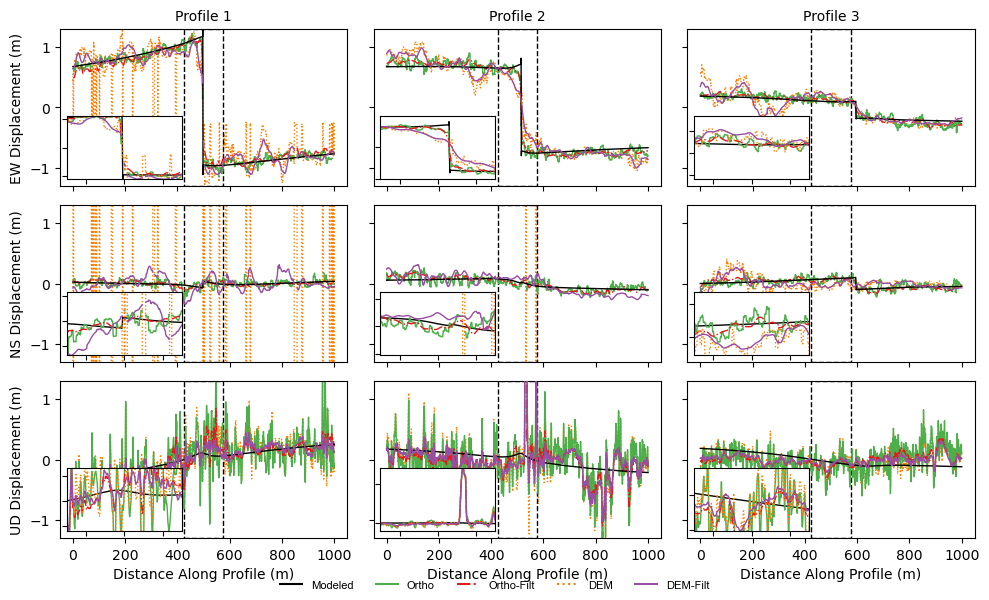

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# Define datasets and displacements
datasets = ['Modeled', 'Ortho', 'Ortho-Filt', 'DEM', 'DEM-Filt']
zorder = [5,2,3,1,5]
displacements = ['EW', 'NS', 'UD']

# Organize profiles by displacement and dataset
profiles_by_group = {disp: {i: [] for i in range(3)} for disp in displacements}
for disp in displacements:
    for i in range(0, 3):  # Assuming three profiles: 1, 2, 3
        profiles_by_group[disp][i] = [
            prof for prof in profile_list if f"Profile_{i}" in prof and f"_{disp}" in prof
        ]

# Define styles for each dataset
dataset_styles = {
    'Modeled': {'color': 'black', 'label': 'Modeled', 'linestyle': '-'},  # Black, solid
    'Ortho': {'color': '#4daf4a', 'label': 'Ortho', 'linestyle': '-'},  # Red, solid
    'Ortho-Filt': {'color': '#e41a1c', 'label': 'Ortho-Filt', 'linestyle': '-.'},  # Green, dash-dot
    'DEM': {'color': '#ff7f00', 'label': 'DEM', 'linestyle': ':'},  # Orange, dotted
    'DEM-Filt': {'color': '#984ea3', 'label': 'DEM-Filt', 'linestyle': '-'}  # Purple, solid
}

# Plotting setup
fig, axes = plt.subplots(3, 3, figsize=(10, 6), sharex=True, sharey=True)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

# Plot data for each displacement (rows) and profile (columns)
for row, disp in enumerate(displacements):  # Rows = EW, NS, UD
    for col in np.arange(3): # Columns = Profile 0,1,2
        ax = axes[row, col]
        profiles = profiles_by_group[disp][col]

        for profile_file in profiles:
            dataset = next((key for key in dataset_styles if key+'_' in profile_file), None)
            if dataset:
                try:
                    # Load profile data
                    data = pd.read_csv(profile_file)
                    x = np.arange(len(data))*0.5  # Assume points are sequential
                    y = data.val - data.val.mean()  # Displacement values
                    # Plot the data
                    ax.plot(
                        x,
                        y,
                        label=dataset_styles[dataset]['label'],
                        color=dataset_styles[dataset]['color'],
                        linestyle=dataset_styles[dataset]['linestyle'],
                        linewidth=1, 
                        zorder=zorder[datasets.index(dataset)]
                    )
                    
                except Exception as e:
                    print(f"Error reading {profile_file}: {e}")

                

        # Title for each column (profiles)
        if row == 0:
            ax.set_title(f"Profile {col + 1}", fontsize=10)
# Adjust range
ax.set_ylim(-1.3,1.3)

# Add rectangles to main plots to indicate the zoom region
fzw = 75 # Fault zone
for ax in axes.flatten():
    rect = Rectangle(
        (500-fzw, ax.get_ylim()[0]),  # Bottom-left corner
        2 * fzw,                                # Width
        ax.get_ylim()[1] - ax.get_ylim()[0],           # Height
        linewidth=1.0,
        edgecolor='black',
        facecolor='none',
        linestyle='--'
    )
    ax.add_patch(rect)

    # Create zoom inset
    # Create inset axes
    inset_ax = inset_axes(ax,width="40%", height="40%", loc="lower left")

    # Re-plot all lines from the main axes onto the inset
    for line in ax.get_lines():
        inset_ax.plot(
            line.get_xdata(),
            line.get_ydata(),
            label=line.get_label(),
            color=line.get_color(),
            linestyle=line.get_linestyle(),
            linewidth=line.get_linewidth()
        )

    # Hide inset ticks for clarity
    inset_ax.set_xlim(500 - fzw, 500 + fzw)
    inset_ax.set_ylim(np.nanmin(line.get_ydata()[line.get_xdata()>500 - fzw]),
                      np.nanmax(line.get_ydata()[line.get_xdata()<500 + fzw]))
    inset_ax.set_xticklabels([])
    inset_ax.set_yticklabels([])

# Add row-specific y-axis labels (displacements)
for row, disp in enumerate(displacements):
    axes[row, 0].set_ylabel(f"{disp} Displacement (m)", fontsize=10)

# Add x-axis labels (distance along profile) for the last row
for col in range(3):
    axes[-1, col].set_xlabel("Distance Along Profile (m)", fontsize=10)

# Consolidate legend
handles, labels = [], []
for style in dataset_styles.values():
    handles.append(plt.Line2D([], [], color=style['color'], linestyle=style['linestyle']))
    labels.append(style['label'])
fig.legend(handles, labels, loc='lower center', ncol=5, fontsize=8, frameon=False)

# Adjust layout
plt.tight_layout(pad=1)  # Leave space for legend
plt.show()



In [10]:
for profile_file in profile_list[3:4]:
            dataset = next((key for key in dataset_styles if key+'_' in profile_file), None)
            if dataset:
                # Load profile data
                data = pd.read_csv(profile_file)
                x = np.arange(len(data))*0.5  # Assume points are sequential
                y = data.val - data.val.mean()  # Displacement values

In [116]:
data.val[np.absolute(data.val.diff())<np.absolute(np.std(data.val.diff()))*0.2]

4      -0.044815
8       0.872858
9       0.871803
11      0.901208
12      0.901092
          ...   
1989    0.001069
1990    0.007353
1993   -0.473129
1997    0.011021
2000   -0.483592
Name: val, Length: 1648, dtype: float64

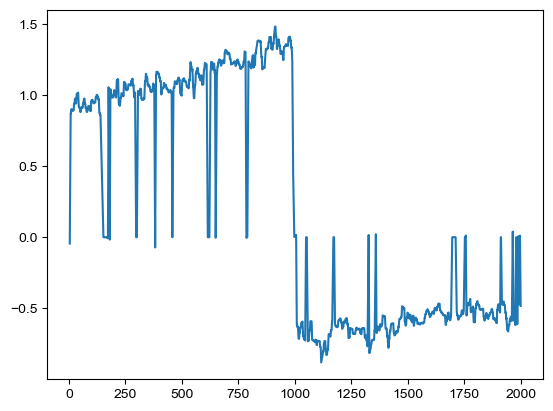

In [115]:
plt.plot(data.val[np.absolute(data.val.diff())<np.absolute(np.std(data.val.diff()))*0.2])

In [91]:
im = rioxarray.open_rasterio('/Volumes/Extreme Pro/Projects/Garlock/Deformation/East/micmac/EWDispStackedEPSG4326.tif')

In [ ]:
im.

(380.0, 400.0)

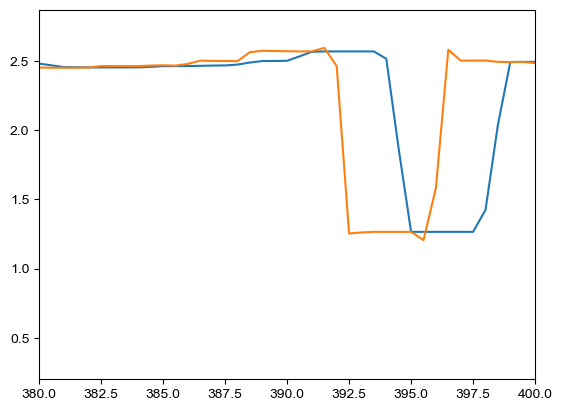

In [84]:
plt.plot(x,data.val.rolling(10).median())
plt.plot(x,data.val)
plt.xlim(380,400)

IndexError: index 9 is out of bounds for axis 0 with size 9

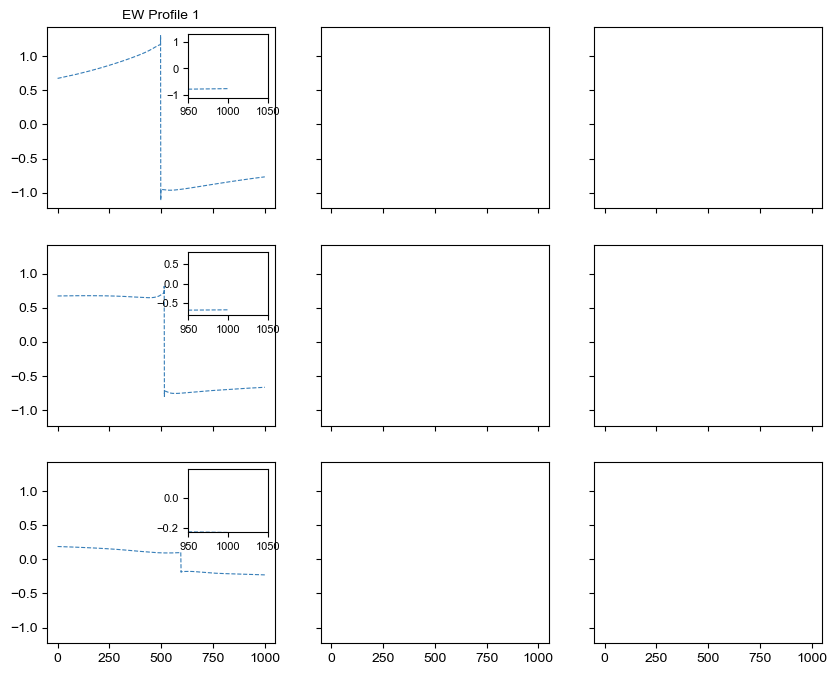

In [21]:
# Define profiles by dataset and displacement
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

datasets = ['Modeled', 'Ortho', 'Ortho_Filt', 'DEM', 'DEM_Filt']
displacements = ['EW', 'NS', 'UD']
profiles_by_group = {disp: [] for disp in displacements}

# Group profiles by displacement direction
for disp in displacements:
    for dataset in datasets:
        matching_profiles = [
            prof for prof in profile_list if f"{dataset}_{disp}" in prof
        ]
        profiles_by_group[disp].extend(matching_profiles)

# Define colorblind-friendly styles for each dataset
dataset_styles = {
    'Modeled': {'color': '#377eb8', 'label': 'Modeled', 'linestyle': '--'},  # Blue, dashed
    'Ortho': {'color': '#e41a1c', 'label': 'Ortho', 'linestyle': '-'},       # Red, solid
    'Ortho_Filt': {'color': '#4daf4a', 'label': 'Ortho-Filt', 'linestyle': '-.'},  # Green, dash-dot
    'DEM': {'color': '#ff7f00', 'label': 'DEM', 'linestyle': ':'},           # Orange, dotted
    'DEM_Filt': {'color': '#984ea3', 'label': 'DEM-Filt', 'linestyle': '-'}  # Purple, solid
}

# Plotting setup
fig, axes = plt.subplots(3, 3, figsize=(10, 8), sharex=True, sharey=True)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
axes = axes.flatten()

# Plot data for each displacement and profile
fault_center = 1000  # Assuming the fault is centered at 1000 meters
zoom_range = 50

for i, (disp, profiles) in enumerate(profiles_by_group.items()):
    for j, profile_file in enumerate(profiles):
        ax = axes[j * 3 + i]
        dataset = next(
            (key for key in dataset_styles if key in profile_file), None
        )
        if dataset:
            # Load profile data
            data = pd.read_csv(profile_file)
            x = np.arange(len(data)) * 0.5  # Assume points are sequential with 0.5m spacing
            y = data['val'] - data['val'].mean()  # Displacement values

            # Plot the data
            ax.plot(
                x,
                y,
                label=dataset_styles[dataset]['label'],
                color=dataset_styles[dataset]['color'],
                linestyle=dataset_styles[dataset]['linestyle'],
                linewidth=0.8
            )

            # Create zoom inset
            inset_ax = inset_axes(ax, width="35%", height="35%", loc="upper right")
            inset_ax.plot(
                x,
                y,
                color=dataset_styles[dataset]['color'],
                linestyle=dataset_styles[dataset]['linestyle'],
                linewidth=0.8
            )
            inset_ax.set_xlim(fault_center - zoom_range, fault_center + zoom_range)
            inset_ax.set_ylim(y.min(), y.max())
            inset_ax.tick_params(labelsize=8)

        # Add title
        if j == 0:
            ax.set_title(f"{disp} Profile {j + 1}", fontsize=10)

# Add labels
for i in range(3):
    axes[i * 3].set_ylabel("Displacement (cm)", fontsize=10)
for i in range(3):
    axes[-3 + i].set_xlabel("Distance Along Profile (m)", fontsize=10)

# Add legend
axes[0].legend(loc='upper right', fontsize=8, frameon=False)

# Adjust layout
plt.tight_layout(pad=1.5)

# Save the plot
#plt.savefig("fault_profiles_zoom.png", dpi=300)
plt.show()

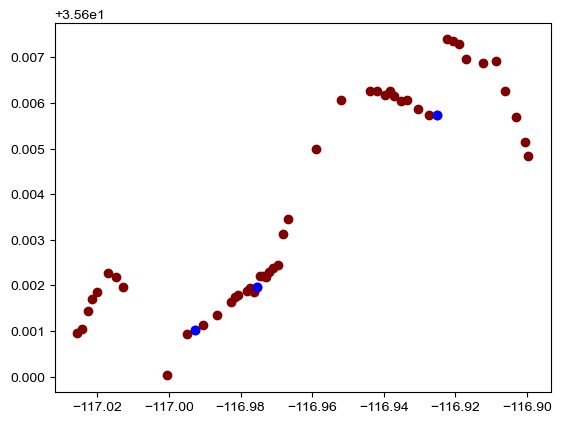

In [ ]:
plt.scatter(lonlist,latlist,c='blue',zorder=10)
plt.scatter(fltpts[:,0],fltpts[:,1],c='maroon')

In [ ]:
# West region, EW
'/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/West/WestdX-rioEPSG4326.tif'
'/Volumes/Extreme Pro/Projects/Garlock/Deformation/West/micmac/EWDispStackedEPSG4326.tif'
'/Volumes/Extreme Pro/Projects/Garlock/Deformation/West/micmac/EWDispStackedEPSG4326_bidenoise_filtered.tif'
'/Volumes/Extreme Pro/Projects/Garlock/Deformation/West/micmac/defaultsMECdem/EWmicmacEPSG4326.tif'
'/Volumes/Extreme Pro/Projects/Garlock/Deformation/West/micmac/defaultsMECdem/EWmicmacEPSG4326_bidenoise_filtered.tif'
# West region, NS
'/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/West/WestdY-rioEPSG4326.tif'
'/Volumes/Extreme Pro/Projects/Garlock/Deformation/West/micmac/NSDispStackedEPSG4326.tif'
'/Volumes/Extreme Pro/Projects/Garlock/Deformation/West/micmac/NSDispStackedEPSG4326_bidenoise_filtered.tif'
'/Volumes/Extreme Pro/Projects/Garlock/Deformation/West/micmac/defaultsMECdem/NSmicmacEPSG4326.tif'
'/Volumes/Extreme Pro/Projects/Garlock/Deformation/West/micmac/defaultsMECdem/NSmicmacEPSG4326_bidenoise_filtered.tif'
# West region, UD
'/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/West/EastdZ-rioEPSG4326.tif'
'/Volumes/Extreme Pro/Projects/Garlock/Deformation/West/micmac/UDfromHDispStackedEPSG4326_bidenoise_filtered.tif'
'/Volumes/Extreme Pro/Projects/Garlock/Deformation/West/micmac/UDfromHDispStackedEPSG4326_bidenoise_filtered_refiltered.tif'
'/Volumes/Extreme Pro/Projects/Garlock/Deformation/West/micmac/defaultsMECdem/UDmicmacEPSG4326_bidenoise_filtered.tif'
'/Volumes/Extreme Pro/Projects/Garlock/Deformation/West/micmac/defaultsMECdem/UDfromHdispStackedEPSG4326_bidenoise_filtered_refiltered.tif'





# For Nadine Caltech group

In [ ]:
imlist = [folder+'EWDispStackedEPSG4326.tif',
          folder+'NSDispStackedEPSG4326.tif',
          folder+'UDDispStackedEPSG4326.tif']

imlist = []

In [13]:
# Define crossprofile 
crossLength = 4000
crossSample = 0.5
crossSpacing = 0.5

In [14]:
fillvalue

NameError: name 'fillvalue' is not defined

In [15]:
for image,direct in zip(imlist,['east (m)','north (m)','up (m)']):
    im = rioxarray.open_rasterio(image).astype(np.double)
    # Get mask and Shift data so that the minimum is zero
    fillvalue = im._FillValue
    mask = ((im != fillvalue) & (im < 255 ) & (im != np.nan)).data
    # Rescale so that negative values are shifted up to 0 or greater
    if im.data[mask].min() < 0:
        im.data[mask] -= im.data[mask].min()
    # set nodata to zero
    im.data[~mask] = 0
    #disparr = im.astype(np.double)

    tmp = pygmt.grdtrack(im,points=fltpts,crossprofile=f'{crossLength}e/{crossSample}e/{crossSpacing}e+v“s{sample_dir}”')
    tmp.columns = ['lon','lat','linedist','az',direct]
    if direct.startswith('e'):
        track = tmp
    else: 
        track[direct] = tmp[direct]

track['az'] = np.round(track.az) # Round azimuth to integer, helps with later grouping of trcaks
ntracks = len(track[track.linedist==0]) # number of cross-profiles
nsamp = int(len(track)/ntracks) # Number of samples per cross-profile

trackids = np.repeat(np.arange(ntracks), nsamp)
track['id'] = trackids # id for each crossprofile

del trackids, tmp

track['perpendicular'] = track['north (m)']*np.cos(-1*track.az*np.pi/180)-track['east (m)']*np.sin(-1*track.az*np.pi/180)
track['parallel'] = track['north (m)']*np.sin(-1*track.az*np.pi/180)+track['east (m)']*np.cos(-1*track.az*np.pi/180)

# Rounding to make dataframe smaller
track['lon'] = np.round(track.lon.values,8)
track['lat'] = np.round(track.lat.values,8)
track['linedist'] = np.round(track.linedist,4)
track['east (m)'] = np.round(track['east (m)'],4)
track['north (m)'] = np.round(track['north (m)'],4)
track['up (m)'] = np.round(track['up (m)'],4)
track['parallel'] = np.round(track['parallel'],4)
track['perpendicular'] = np.round(track['perpendicular'],4)

/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/pygmt/src/grdtrack.py:309: RuntimeWarning: Input image has dtype: float64 which is unsupported, and may result in an incorrect output. Please recast image to a uint8 dtype and/or scale to 0-255 range, e.g. using a histogram equalization function like skimage.exposure.equalize_hist.
  lib.virtualfile_in(check_kind="raster", data=grid) as vingrd,
grdtrack [WARNING]: Some points along your profiles were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).
/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/pygmt/src/grdtrack.py:309: RuntimeWarning: Input image has dtype: float64 which is unsupported, and may result in an incorrect output. Please recast image to a uint8 dtype and/or scale to 0-255 range, e.g. using a histogram equalization function like skimage.exposure.equalize_hist.
  lib.virtualfile_in(check_kind="raster", data=grid) as vingrd,
grdtrack [WARNIN

In [61]:
# Save
save = False
if save == True:
    track.to_csv(folder+'GarlockEastProfilesAll.txt',index=False)
else:
    print('Not saving or overwriting the file')

In [32]:
save = True

In [33]:
# Create sub-files with 10-m along track groups
prof_folder = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/splitProfiles/'
nprof = 200 # number of profiles per file
nfiles = int(np.ceil(len(np.unique(track.id))/nprof)) # number of files
if save == True:
    for i in range(0,nfiles):
        track[(track.id >=  i*nprof) & (track.id < i*nprof+nprof)].to_csv(prof_folder+f'GarlockEastProfiles{int(i*nprof)}to{int(i*nprof+nprof)}.txt',index=False)
else:
    print('Not saving or overwriting the file')

In [53]:
#track.to_hdf(folder+'GarlockEastProfilesAll.h5', key='df', mode='w',complevel=9) 

In [22]:
pdf

,lon,lat,linedist,az,east (m),north (m),up (m),id,parallel,perpendicular
800100,-117.023279,35.583064,-1997.1372,355.0,1.6644,1.1949,16.9372,100,1.7622,1.0453
800101,-117.023279,35.583069,-1996.6379,355.0,1.6669,1.1946,16.8770,100,1.7646,1.0448
800102,-117.023280,35.583073,-1996.1386,355.0,1.6657,1.1925,16.8259,100,1.7633,1.0428
800103,-117.023280,35.583078,-1995.6394,355.0,1.6659,1.1910,16.7588,100,1.7633,1.0413
800104,-117.023280,35.583082,-1995.1401,355.0,1.6518,1.1848,16.7604,100,1.7488,1.0363
...,...,...,...,...,...,...,...,...,...,...
808096,-117.026886,35.618899,1995.1454,355.0,NaN,NaN,NaN,100,NaN,NaN
808097,-117.026887,35.618904,1995.6446,355.0,NaN,NaN,NaN,100,NaN,NaN
808098,-117.026887,35.618908,1996.1439,355.0,NaN,NaN,NaN,100,NaN,NaN
808099,-117.026888,35.618913,1996.6432,355.0,NaN,NaN,NaN,100,NaN,NaN


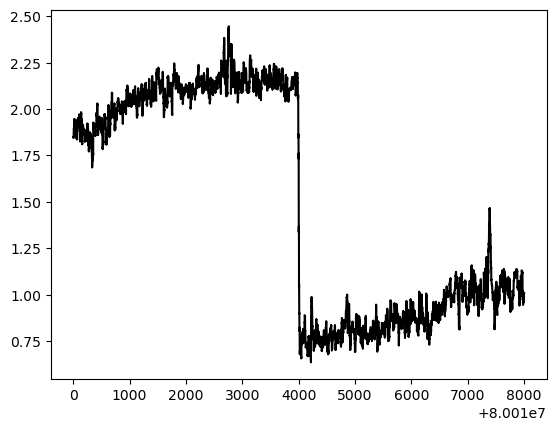

In [31]:
pdf = track[track.id == 10000]

plt.plot(pdf['parallel'],c='black')


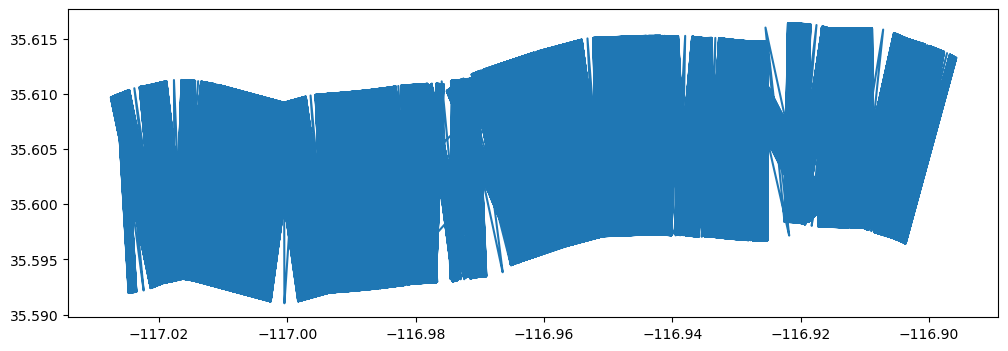

In [164]:
plt.figure(figsize=(12,4))
plt.plot(tmp.lon,tmp.lat)

In [177]:
tmp

,lon,lat,linedist,az,val,stackmean,stdev
0,-117.024731,35.591991,-998.569262,355.320450,3.479599,3.371860,0.199704
1,-117.024731,35.591995,-998.069977,355.320450,3.479032,3.372163,0.199444
2,-117.024732,35.592000,-997.570693,355.320450,3.478512,3.372467,0.199185
3,-117.024732,35.592004,-997.071409,355.320449,3.478042,3.372771,0.198929
4,-117.024732,35.592009,-996.572124,355.320449,3.477621,3.373074,0.198677
...,...,...,...,...,...,...,...
92835198,-116.895794,35.613227,996.931077,20.898948,NaN,2.475151,0.234705
92835199,-116.895792,35.613231,997.430542,20.898949,NaN,2.475167,0.234791
92835200,-116.895790,35.613235,997.930007,20.898950,NaN,2.475162,0.234872
92835201,-116.895788,35.613239,998.429472,20.898952,NaN,2.475160,0.234954


In [191]:
tmp.iloc[::int(proflen)]

,lon,lat,linedist,az,val,stackmean,stdev
0,-117.024731,35.591991,-998.569262,355.320450,3.479599,3.37186,0.199704
4001,-117.024725,35.591991,-998.569262,355.320453,3.481037,3.37186,0.199704
8002,-117.024720,35.591992,-998.569262,355.320456,3.482451,3.37186,0.199704
12003,-117.024714,35.591992,-998.569262,355.320459,3.483839,3.37186,0.199704
16004,-117.024709,35.591992,-998.569262,355.320463,3.485200,3.37186,0.199704
...,...,...,...,...,...,...,...
92815198,-116.903698,35.596447,-998.927696,20.894348,3.061348,3.37186,0.199704
92819199,-116.903692,35.596445,-998.927696,20.894351,3.059313,3.37186,0.199704
92823200,-116.903687,35.596443,-998.927696,20.894354,3.057309,3.37186,0.199704
92827201,-116.903682,35.596442,-998.927696,20.894357,3.055340,3.37186,0.199704


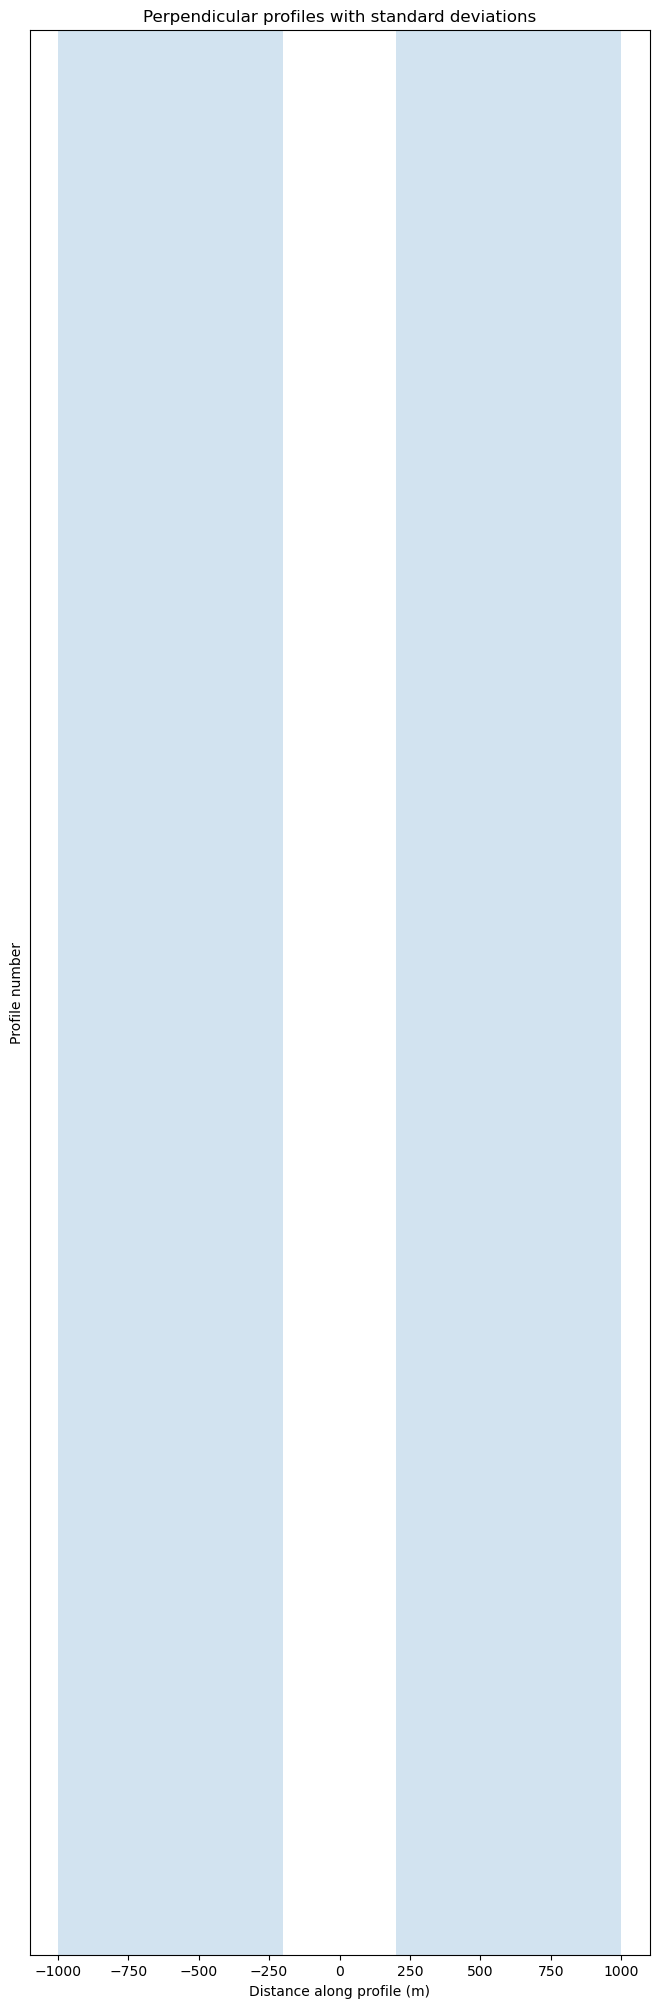

In [192]:
## Good one!tmp.iloc[121*100:121*221+121]
track = tmp
shift = 1
# Profile taken at 
distance = [200,1000]
bmin, bmax = int(distance[0]/crossSample),int(distance[1]/crossSample)#150,250
proflen = np.floor(crossLength/crossSample)+1
meandisp = {'perp':[]}#,'par':[],'vert':[]}
stdev = {'perp':[]}#,'par':[],'vert':[]}
trackdist = {'perp':[]}#,'par':[],'vert':[]}

for track, j, title in zip([track], meandisp.keys(),['Perpendicular']):
    plt.figure(figsize=(8,25))
    plt.title(f'{title} profiles with standard deviations')

    yticks = []
    yticklabels = []
    last_y = None  # To track the y-position of the last label
    
    for i in range(0,len(track[track.linedist==0])):
        prof = track.iloc[int(i*proflen):int(proflen+i*proflen)]
        print(i,prof[prof.linedist > distance[0]].val.mean()-prof[prof.linedist <= -distance[0]].val.mean())
        
        y_position = (i + 1)  # Ensure y_position is starting from 1 through 25
        profile_line = prof.val - prof.val.iloc[0] + y_position * shift
        plt.plot(prof.linedist, profile_line)
        plt.fill_between(prof.linedist, profile_line - prof.stdev, profile_line + prof.stdev, alpha=0.2)

        # Determine the annotation y-position to avoid overlap
        label_y = profile_line.iloc[-1]
        if last_y is not None and abs(label_y - last_y) < 0.5:  # Adjust this threshold as needed
            label_y += 0.8  # Shift the label up by 0.5 units if too close to the previous one

        last_y = label_y  # Update last_y to the current label's y-position

        yticks.append(y_position * shift)
        yticklabels.append(str(int(y_position)))

    plt.axvspan(distance[0],distance[1],alpha=0.2)
    plt.axvspan(-distance[0],-distance[1],alpha=0.2)
    plt.yticks(yticks, yticklabels)
    plt.xlabel('Distance along profile (m)')
    plt.ylabel('Profile number')


In [9]:
for image in imlist:
    im = rioxarray.open_rasterio(image)
    # Get mask and Shift data so that the minimum is zero
    fillvalue = im._FillValue
    mask = ((im != fillvalue) & (im < 255 ) & (im != np.nan)).data
    # Rescale so that negative values are shifted up to 0 or greater
    if im.data[mask].min() < 0:
        im.data[mask] -= im.data[mask].min()
    # set nodata to zero
    im.data[~mask] = 0
    disparr = im.astype(np.double)
    # Create crossprofiles along a line
    # 2 endpoints provided in pts
    # crossprofiles are length/sample spacing along profile/space between each profile
    # e is the unit notation for meter
    # stack a means the mean value (a is average) appended to each profile (+a), +da appends standard deviation too
    # Output is lon, lat, dist, azimuth,value of grid, mean of stack, stdev of stack
    track = pd.DataFrame(columns=['id','lon','lat','linedist','az','val','stackmean','stdev'])
    for i in range(0,len(pts)-1):
        tmp = pygmt.grdtrack(disparr,points=np.array([pts[i],pts[i+1]]),binary='id',
                                crossprofile=f'{crossLength}e/{crossSample}e/{crossSpacing}e',stack='a+a+dm')
        tmp.columns = ['lon','lat','linedist','az','val','stackmean','stdev']
        tmp['id'] = np.ones(len(tmp))*i
        # replace lon of individual profile with center of stack
        #tmp['lon'] = np.ones(len(tmp))*tmp['lon'][tmp.linedist == 0].median()
        #tmp['lat'] = np.ones(len(tmp))*tmp['lat'][tmp.linedist == 0].median()
        track = pd.concat([track,tmp],axis=0,ignore_index=True)
    #track.drop(columns=['val'],inplace=True)
    print('Hi')

    #if image is imlist[0]:
    #    #track.to_csv('/Users/chanagan/Desktop/DGStereo/TienShan/micmac/PerpendicularProfiles.txt')
    #elif image is imlist[1]:
    #    #track.to_csv('/Users/chanagan/Desktop/DGStereo/TienShan/micmac/ParallelProfiles.txt')
    #elif image is imlist[2]:
        #track.to_csv('/Users/chanagan/Desktop/DGStereo/TienShan/micmac/VerticalProfiles.txt')


/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/pygmt/src/grdtrack.py:309: RuntimeWarning: Input image has dtype: float64 which is unsupported, and may result in an incorrect output. Please recast image to a uint8 dtype and/or scale to 0-255 range, e.g. using a histogram equalization function like skimage.exposure.equalize_hist.
  lib.virtualfile_in(check_kind="raster", data=grid) as vingrd,
grdtrack [WARNING]: Some points along your profiles were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).
/var/folders/zn/w54gt7k11csfs1n4z8r3xccsyqhmjz/T/ipykernel_67729/2931332651.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  track = pd.concat([track,tmp],axis=0,ignore_index=T

Hi


In [13]:
meandisp.keys()

dict_keys(['perp'])

AttributeError: 'DataFrame' object has no attribute 'id'

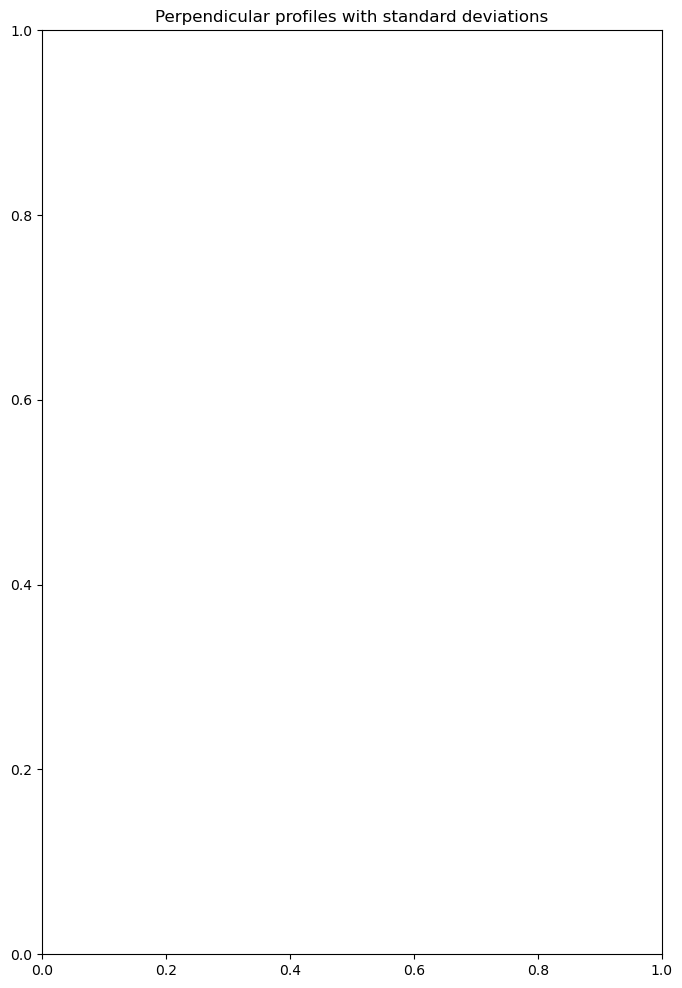

In [61]:
## Good one!
track = tmp
shift = 1
# Profile taken at 
distance = [300,500]
bmin, bmax = int(distance[0]/crossSample),int(distance[1]/crossSample)#150,250
meandisp = {'perp':[]}#,'par':[],'vert':[]}
stdev = {'perp':[]}#,'par':[],'vert':[]}
trackdist = {'perp':[]}#,'par':[],'vert':[]}
centerlats = {'perp':[]}#,'par':[],'vert':[]}
centerlons = {'perp':[]}#,'par':[],'vert':[]}
for track, j, title in zip([track], meandisp.keys(),['Perpendicular']):
    plt.figure(figsize=(8,12))
    plt.title(f'{title} profiles with standard deviations')

    yticks = []
    yticklabels = []
    last_y = None  # To track the y-position of the last label
    
    for i in track.id.unique():
        prof = track[track.id==i]
        print(i,prof[prof.linedist > distance[0]].stackmean.mean()-prof[prof.linedist <= -distance[0]].stackmean.mean())
        meandisp[j].append(prof[prof.linedist > distance[0]].stackmean.mean()-prof[prof.linedist <= -distance[0]].stackmean.mean())
        stdev[j].append(np.std(prof[prof.linedist > distance[0]].stackmean.values-prof[prof.linedist <= -distance[0]].stackmean.values))
        trackdist[j].append(i+1)
        if i == np.median(track.id.unique()):
            centerlons[j].append(prof.lon.unique())
            centerlats[j].append(prof.lat.unique())
        
        y_position = (i + 1)  # Ensure y_position is starting from 1 through 25
        profile_line = prof.stackmean - prof.stackmean.iloc[0] + y_position * shift
        plt.plot(prof.linedist, profile_line)
        plt.fill_between(prof.linedist, profile_line - prof.stdev, profile_line + prof.stdev, alpha=0.2)

        # Determine the annotation y-position to avoid overlap
        label_y = profile_line.iloc[-1]
        if last_y is not None and abs(label_y - last_y) < 0.5:  # Adjust this threshold as needed
            label_y += 0.8  # Shift the label up by 0.5 units if too close to the previous one

        # Annotate the meandisp near the right edge of the plot, with the span in parentheses
        plt.annotate(f'{meandisp[j][int(i)]:.2f} m',
                     xy=(prof.linedist.max(), profile_line.iloc[-1]),  # Position at the right edge of the profile
                     xytext=(prof.linedist.max() + 50, label_y),  # Adjusted label position to avoid overlap
                     arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
                     fontsize=10, color='black', ha='left')

        last_y = label_y  # Update last_y to the current label's y-position

        yticks.append(y_position * shift)
        yticklabels.append(str(int(y_position)))

    plt.axvspan(distance[0],distance[1],alpha=0.2)
    plt.axvspan(-distance[0],-distance[1],alpha=0.2)
    plt.yticks(yticks, yticklabels)
    plt.xlabel('Distance along profile (m)')
    plt.ylabel('Profile number')
    shift = 1

In [22]:
tmp

,lon,lat,linedist,az,val,stackmean,stdev,id
0,-117.023499,35.592073,-998.569268,355.321167,NaN,0.0,NaN,49.0
1,-117.023589,35.592969,-898.712400,355.321167,NaN,0.0,NaN,49.0
2,-117.023679,35.593865,-798.855520,355.321114,NaN,0.0,NaN,49.0
3,-117.023769,35.594762,-698.998626,355.321062,NaN,0.0,NaN,49.0
4,-117.023860,35.595658,-599.141719,355.321009,NaN,0.0,NaN,49.0
5,-117.023950,35.596554,-499.284799,355.320957,NaN,0.0,NaN,49.0
6,-117.024040,35.597451,-399.427866,355.320904,NaN,0.0,NaN,49.0
7,-117.024130,35.598347,-299.570919,355.320852,NaN,0.0,NaN,49.0
8,-117.024221,35.599243,-199.713959,355.320799,NaN,0.0,NaN,49.0
9,-117.024311,35.600140,-99.856986,355.320747,NaN,0.0,NaN,49.0


In [33]:
np.sqrt(tracedf.iloc[-1].x**2+tracedf.iloc[-1].y**2) -np.sqrt(tracedf.iloc[-2].x**2+tracedf.iloc[-2].y**2)

-22.982203418854624